<a href="https://colab.research.google.com/github/AtSourav/AE-n-VAE-with-CB-loss-on-stl10/blob/main/AE_stl10_mse_HeNormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
img_ht = 48
img_wd = 48

input_size = (img_ht,img_wd,3)
latent_dim = 256
batch_size = 512

#initializer = initializers.GlorotNormal()
initializer = initializers.HeNormal(seed=123)

In [3]:
ds = tfds.load('stl10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/1.0.0.incompleteJ5KWHH/stl10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/1.0.0.incompleteJ5KWHH/stl10-test.tfrecord*...:   0%|          | 0/8…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/1.0.0.incompleteJ5KWHH/stl10-unlabelled.tfrecord*...:   0%|         …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [4]:
ds2 = tfds.load('stl10', split='train')

In [5]:
ds3 = tfds.load('stl10', split='unlabelled[:2%]')

In [6]:
ds_to_np = list(ds.as_numpy_iterator())+list(ds2.as_numpy_iterator()) +list(ds3.as_numpy_iterator())

In [7]:
print(set(tuple(x.keys()) for x in ds_to_np))                # we converted the list of keys into a tuple since we wanted to use set() for duplicate removal
                                                             # set() only works on hashable objects like strings, numbers, and tuples,
                                                             # and not on mutables like dicts and strings

print(set(x['label'] for x in ds_to_np))
print(set(type(x['image']) for x in ds_to_np))
print(set(x['image'].shape for x in ds_to_np))
print(len(ds_to_np))

{('image', 'label')}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
{<class 'numpy.ndarray'>}
{(96, 96, 3)}
15000


ds_to_np is a list of dictionaries where the key:value pairs are the 'image':img_ndarray, 'label'=-1. We want to collect all these arrays and form a tensor/array. There are 100k images. We'll use 50k of them in the training set, 25k for validation, and 25k for the test set.

In [9]:
random.seed(100)
random.shuffle(ds_to_np)                                    # random permutation in place
img_train = np.array([x['image'] for x in ds_to_np[:12000]])
img_valid = np.array([x['image'] for x in ds_to_np[12000:13000]])
#img_test = np.array([x['image'] for x in ds_to_np[13000:]])

img_train = img_train/255
img_valid = img_valid/255
#img_test = img_test/255

In [ ]:
print(img_train.shape)

(12000, 96, 96, 3)


In [10]:
img_train = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_train)
print(img_train.shape)

img_valid = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_valid)
print(img_valid.shape)

#img_test = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_test)
#print(img_valid.shape)

(12000, 48, 48, 3)
(1000, 48, 48, 3)


In [11]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(8, 2, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(16, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="same", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="same", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2D(512, 2, padding="valid")(x)
#x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2D(1024, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Flatten()(x)

#x = layers.Dense(2*latent_dim)(x)
#x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 47, 47, 8)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 8)         0         
 D)                                                              
                                                                 
 re_lu (ReLU)                (None, 23, 23, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        528       
                                                                 
 re_lu_1 (ReLU)              (None, 22, 22, 16)        0         
                                                           

In [12]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(1*1*2048)(latent_input)
x = layers.ReLU()(x)
x = layers.Reshape((2,2,512))(x)

#x = layers.Dense(1*1*512)(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(1024, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(512, 2, strides=1, padding='valid')(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, strides=1, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, strides=2, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, strides=2, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(32, 2, strides=1, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, 2, strides=1, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(32, 2, strides=1, padding='same')(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(8, 2, strides=1, padding='same')(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(8, 2, strides=1, padding='same', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 2, activation='sigmoid', strides=1, padding='same', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 2048)              526336    
                                                                 
 re_lu_14 (ReLU)             (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 3, 3, 512)         1049088   
 anspose)                                                        
                                                                 
 re_lu_15 (ReLU)             (None, 3, 3, 512)         0         
                                                           

In [13]:
decoder_out = decoder(encoder(encoder_input))
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               3192152   
                                                                 
 decoder (Functional)        (None, 48, 48, 3)         4341083   
                                                                 
Total params: 7533235 (28.74 MB)
Trainable params: 7533235 (28.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
K.clear_session()

In [16]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.98)
optim = keras.optimizers.Adam(learning_rate = 0.001)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss='mse')

In [17]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=100, steps_per_epoch=None)

Epoch 1/100
24/24 [==============================] - 43s 656ms/step - loss: 0.0680 - val_loss: 0.0662
Epoch 2/100
24/24 [==============================] - 7s 283ms/step - loss: 0.0662 - val_loss: 0.0656
Epoch 3/100
24/24 [==============================] - 7s 281ms/step - loss: 0.0654 - val_loss: 0.0641
Epoch 4/100
24/24 [==============================] - 7s 283ms/step - loss: 0.0631 - val_loss: 0.0588
Epoch 5/100
24/24 [==============================] - 7s 276ms/step - loss: 0.0602 - val_loss: 0.0544
Epoch 6/100
24/24 [==============================] - 7s 280ms/step - loss: 0.0547 - val_loss: 0.0526
Epoch 7/100
24/24 [==============================] - 7s 278ms/step - loss: 0.0488 - val_loss: 0.0454
Epoch 8/100
24/24 [==============================] - 7s 277ms/step - loss: 0.0441 - val_loss: 0.0406
Epoch 9/100
24/24 [==============================] - 7s 272ms/step - loss: 0.0402 - val_loss: 0.0386
Epoch 10/100
24/24 [==============================] - 6s 270ms/step - loss: 0.0372 - val_l

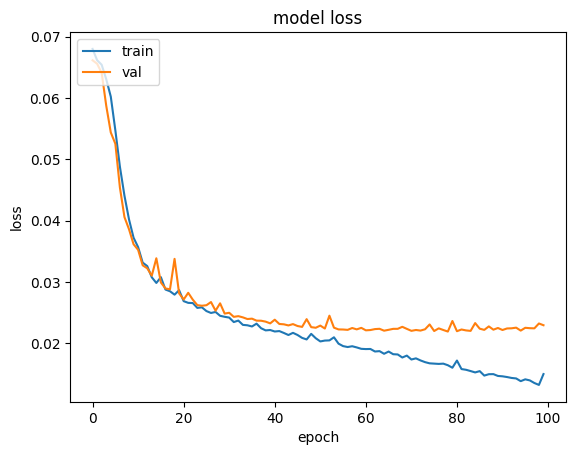

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.00075)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)
history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50, steps_per_epoch=None)

Epoch 1/50
24/24 [==============================] - 16s 335ms/step - loss: 1.3355 - val_loss: 1.3289
Epoch 2/50
24/24 [==============================] - 7s 302ms/step - loss: 1.3240 - val_loss: 1.3266
Epoch 3/50
24/24 [==============================] - 7s 306ms/step - loss: 1.3206 - val_loss: 1.3268
Epoch 4/50
24/24 [==============================] - 7s 301ms/step - loss: 1.3183 - val_loss: 1.3267
Epoch 5/50
24/24 [==============================] - 7s 296ms/step - loss: 1.3168 - val_loss: 1.3268
Epoch 6/50
24/24 [==============================] - 7s 293ms/step - loss: 1.3152 - val_loss: 1.3268
Epoch 7/50
24/24 [==============================] - 7s 290ms/step - loss: 1.3139 - val_loss: 1.3270
Epoch 8/50
24/24 [==============================] - 7s 289ms/step - loss: 1.3132 - val_loss: 1.3274
Epoch 9/50
24/24 [==============================] - 7s 288ms/step - loss: 1.3129 - val_loss: 1.3271
Epoch 10/50
24/24 [==============================] - 7s 297ms/step - loss: 1.3126 - val_loss: 1.327

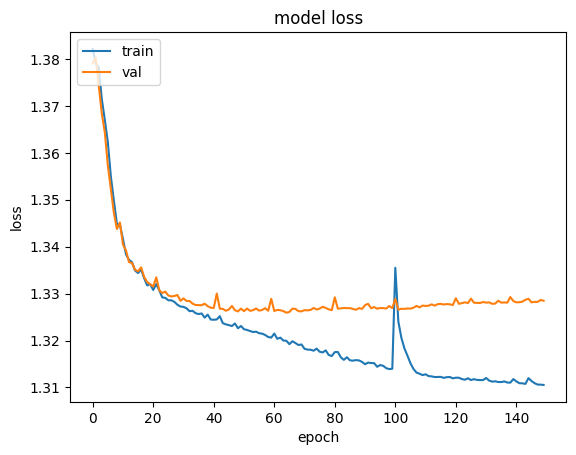

In [ ]:
plt.plot(history.history['loss']+history2.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(18,8))    # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim = 512', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((64,64,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

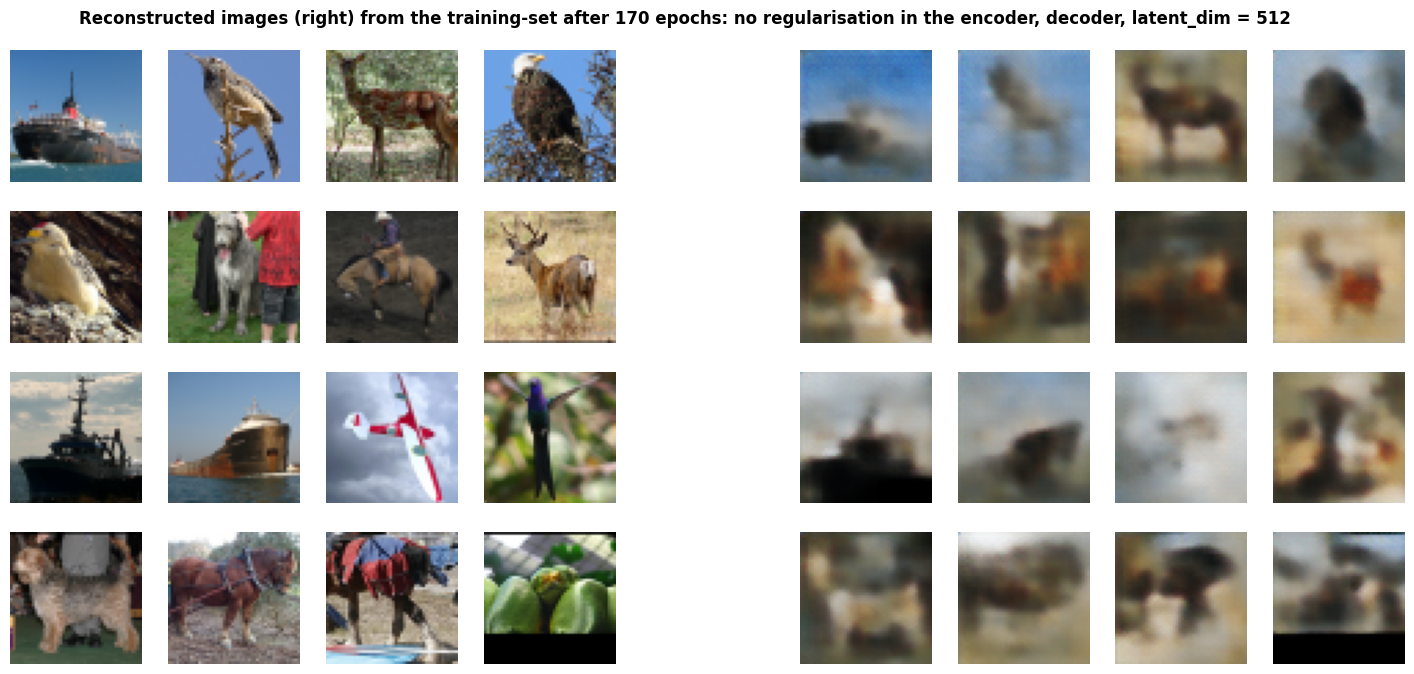

In [20]:
plot_reconstruction(img_train, 'training', 100, 170)